In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, warnings
from concurrent.futures import ThreadPoolExecutor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas option for displaying all columns
pd.options.display.max_columns = None

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# Load datasets
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

# Load time series data
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

# Merge datasets
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


In [4]:
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,

In [5]:
test.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,

In [6]:
train.shape,test.shape

((3960, 177), (20, 154))

In [7]:
train_ts.shape,test_ts.shape


((996, 97), (2, 97))

In [8]:
missing_cols=set(train)-set(test)
missing_cols.remove('sii')
missing_cols

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season'}

In [9]:
train.isna().sum()

Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
CGAS-CGAS_Score                           1539
Physical-Season                            650
Physical-BMI                               938
Physical-Height                            933
Physical-Weight                            884
Physical-Waist_Circumference              3062
Physical-Diastolic_BP                     1006
Physical-HeartRate                         993
Physical-Systolic_BP                      1006
Fitness_Endurance-Season                  2652
Fitness_Endurance-Max_Stage               3217
Fitness_Endurance-Time_Mins               3220
Fitness_Endurance-Time_Sec                3220
FGC-Season                                 614
FGC-FGC_CU                                1638
FGC-FGC_CU_Zone                           1678
FGC-FGC_GSND                              2886
FGC-FGC_GSND_

### Feature Engineering

##### - Dropping features

In [10]:
# dropping features with equal to or more than 50% of missing values 
def dropMissingValueFeatures(train,test):
    missing_train = train.isna().mean() * 100
    cols_to_drop = missing_train[missing_train >= 50].index.tolist()
    cols_to_drop+=[i for i in train.columns if 'BIA' in i]

    train=train.drop(columns=[col for col in cols_to_drop if col in train.columns], axis=1)
    test=test.drop(columns=[col for col in cols_to_drop if col in test.columns], axis=1)
    return train,test

In [11]:
train,test=dropMissingValueFeatures(train,test)

In [12]:
missing_train = train.isna().mean() * 100
missing_test = test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train >0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test >0])

Columns with missing values in df_train:
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
Physical-Season                           16.414141
Physical-BMI                              23.686869
Physical-Height                           23.560606
Physical-Weight                           22.323232
Physical-Diastolic_BP                     25.404040
Physical-HeartRate                        25.075758
Physical-Systolic_BP                      25.404040
FGC-Season                                15.505051
FGC-FGC_CU                                41.363636
FGC-FGC_CU_Zone                           42.373737
FGC-FGC_PU                                41.666667
FGC-FGC_PU_Zone                           42.651515
FGC-FGC_SRL                               41.792929
FGC-FGC_SRL_Zone                          42.752525
FGC-FGC_SRR                               41.742424
FGC-FGC_SRR_Zone                          42.702020
FGC-FGC_TL             

In [13]:
train.shape[1]-test.shape[1]

23

In [14]:
wa = pd.DataFrame(data=train, columns=['PCIAT-PCIAT_Total', 'sii'])
wa[pd.notna(wa['PCIAT-PCIAT_Total'])]

,PCIAT-PCIAT_Total,sii
0,55.0,2.0
1,0.0,0.0
2,28.0,0.0
3,44.0,1.0
5,34.0,1.0
...,...,...
3953,22.0,0.0
3954,33.0,1.0
3955,32.0,1.0
3957,31.0,1.0


In [15]:
train_pciatAvg=train.copy()
test_pciatAvg=test.copy()
pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]
train_pciatAvg['Pciat_total_min']=train_pciatAvg[pciat_columns].fillna(0).sum(axis=1)
train_pciatAvg['Pciat_total_max']=train_pciatAvg[pciat_columns].fillna(5).sum(axis=1)
train_pciatAvg['Pciat_total_avg']=(train_pciatAvg['Pciat_total_max']+train_pciatAvg['Pciat_total_min'])/2
train_pciatAvg.drop(columns=['Pciat_total_max','Pciat_total_min','PCIAT-PCIAT_Total', 'PCIAT-Season','sii'] + pciat_columns, inplace=True)

def calSii(total):
    if total<=30:
        return 0  # None
    elif 31 <= total <= 49:
        return 1  # Mild
    elif 50 <= total <= 79:
        return 2  # Moderate
    else:
        return 3  # Severe

train_pciatAvg['sii_pred']=train_pciatAvg['Pciat_total_avg'].apply(calSii)
train_pciatAvg.drop('Pciat_total_avg',axis=1)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii_pred
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,Fall,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,NaN,NaN,NaN,Fall,3.0,2
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,75.0,70.0,122.0,Fall,3.0,0.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Fall,46.0,64.0,Summer,0.0,0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,65.0,94.0,117.0,Fall,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,Fall,38.0,54.0,Summer,2.0,0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,60.0,97.0,117.0,Summer,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,31.0,45.0,Winter,0.0,1
4,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,71.0,70.0,104.0,Fall,16.0,0.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Winter,35.0,50.0,Fall,1.0,1
3956,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,60.0,78.0,118.0,Spring,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,NaN,NaN,NaN,Winter,0.0,2
3957,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,79.0,99.0,116.0,Winter,15.0,1.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,Winter,56.0,77.0,Fall,0.0,1
3958,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,59.0,61.0,113.0,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,33.0,47.0,Spring,1.0,0


In [16]:
missing_train = train_pciatAvg.isna().mean() * 100
missing_test = test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train >0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test >0])

Columns with missing values in df_train:
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
Physical-Season                           16.414141
Physical-BMI                              23.686869
Physical-Height                           23.560606
Physical-Weight                           22.323232
Physical-Diastolic_BP                     25.404040
Physical-HeartRate                        25.075758
Physical-Systolic_BP                      25.404040
FGC-Season                                15.505051
FGC-FGC_CU                                41.363636
FGC-FGC_CU_Zone                           42.373737
FGC-FGC_PU                                41.666667
FGC-FGC_PU_Zone                           42.651515
FGC-FGC_SRL                               41.792929
FGC-FGC_SRL_Zone                          42.752525
FGC-FGC_SRR                               41.742424
FGC-FGC_SRR_Zone                          42.702020
FGC-FGC_TL             

In [17]:
train_pciatAvg.shape,test.shape

((3960, 30), (20, 28))

In [18]:
train_pciatAvg.sample(5)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,Pciat_total_avg,sii_pred
1962,Fall,17,0,Spring,68.0,Winter,17.817992,63.5,102.2,72.0,77.0,135.0,Winter,25.0,1.0,NaN,NaN,10.0,1.0,9.0,1.0,7.0,0.0,Winter,54.0,75.0,Fall,1.0,70.5,2
2403,Fall,13,0,Spring,78.0,Winter,17.010208,57.5,80.0,60.0,63.0,104.0,Winter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,32.0,46.0,Fall,0.0,27.0,0
2835,Summer,7,0,Spring,55.0,Fall,14.991087,49.0,51.2,58.0,79.0,107.0,Fall,6.0,1.0,3.0,0.0,8.0,1.0,9.0,1.0,9.0,1.0,Fall,37.0,53.0,Summer,0.0,0.0,0
660,Winter,11,1,Summer,51.0,Spring,17.612866,57.0,81.4,78.0,72.0,117.0,Spring,13.0,0.0,10.0,1.0,6.0,0.0,6.0,0.0,8.0,0.0,Spring,45.0,63.0,Winter,1.0,39.0,1
843,Fall,11,0,Spring,65.0,Fall,17.197355,55.0,74.0,66.0,78.0,108.0,Fall,10.0,0.0,6.0,0.0,8.0,1.0,8.0,1.0,10.0,1.0,NaN,NaN,NaN,Fall,1.0,27.5,0


In [19]:
test.sample(5)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
19,Winter,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,2.0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,65.0,94.0,117.0,Fall,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,Fall,38.0,54.0,Summer,2.0
10,Spring,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN
8,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.0
9,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### - Encoding Age_Group and Basic_Demos-Sex

PreInt_EduHx-computerinternet_hoursday    1.000000
Basic_Demos-Age                           0.441822
SDS-SDS_Total_T                           0.086050
SDS-SDS_Total_Raw                         0.083501
Age_Group_Adults                          0.146514
Age_Group_Children                       -0.389975
Basic_Demos-Sex_1                        -0.000579
Name: PreInt_EduHx-computerinternet_hoursday, dtype: float64


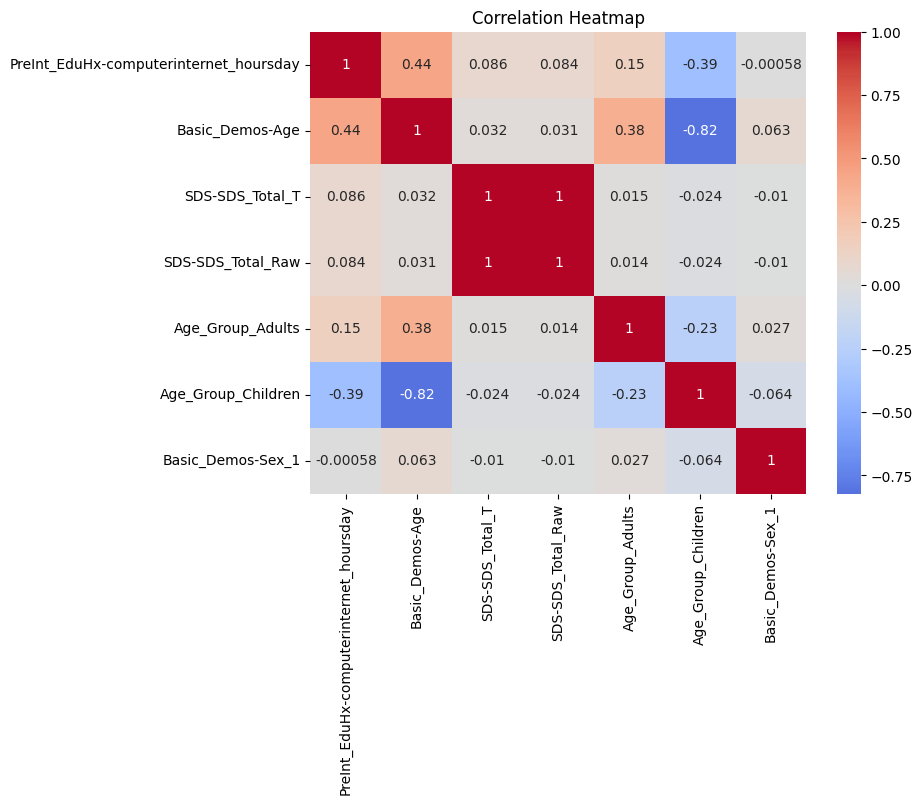

In [20]:
from sklearn.preprocessing import OneHotEncoder

# Exclude rows where 'PreInt_EduHx-computerinternet_hoursday' is NaN and select relevant columns
filtered_data = train_pciatAvg[train_pciatAvg['PreInt_EduHx-computerinternet_hoursday'].notna()][['PreInt_EduHx-computerinternet_hoursday','Basic_Demos-Age', 'Basic_Demos-Sex','SDS-SDS_Total_T', 'SDS-SDS_Total_Raw']]

# Create Age_Group
filtered_data['Age_Group'] = pd.cut(filtered_data['Basic_Demos-Age'], bins=[4, 12, 18, 22], labels=['Children', 'Adolescents', 'Adults'])

# OneHotEncode both Age_Group and Basic_Demos-Sex
drop_enc = OneHotEncoder(drop='first', sparse=False)
categorical_cols = ['Age_Group', 'Basic_Demos-Sex']
encoded_cols = drop_enc.fit_transform(filtered_data[categorical_cols])

# Create DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded_cols, columns=drop_enc.get_feature_names_out(categorical_cols))

# Concatenate encoded columns with the original filtered_data
filtered_data = pd.concat([filtered_data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Now you can drop the original categorical columns if needed
filtered_data.drop(categorical_cols, axis=1, inplace=True)

# Calculate the correlation matrix
corr_matrix = filtered_data.corr()
print(filtered_data.corr()['PreInt_EduHx-computerinternet_hoursday'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

##### - Imputing features

In [21]:
def imputing(df):
    # Step 1: Impute categorical season columns using mode
    fill_with_mode = ['CGAS-Season', 'Physical-Season', 'FGC-Season', 'SDS-Season', 'PreInt_EduHx-Season']
    for col in fill_with_mode:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # Step 2: Impute numeric columns with median
    df['CGAS-CGAS_Score'] = df['CGAS-CGAS_Score'].fillna(df['CGAS-CGAS_Score'].median())

    # Step 3: Grouping by age group and sex
    df['Age_Group'] = pd.cut(df['Basic_Demos-Age'], bins=[4, 12, 18, 22], labels=['Children', 'Adolescents', 'Adults'])
    group_cols = ['Age_Group', 'Basic_Demos-Sex']

    # Step 4: Impute 'Physical-Weight' and 'Physical-Height'
    for col in ['Physical-Weight', 'Physical-Height']:
        # Step 4a: Impute based on Age Group + Sex
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))

        # Step 4b: Fallback to age group median only for rows still missing values
        missing_vals_mask = df[col].isna()  # Create a mask for NaN values
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby('Age_Group')[col].transform(lambda x: x.fillna(x.median()))

        # Step 4c: Final fallback to overall median only for remaining missing values
        df.loc[df[col].isna(), col] = df[col].median()  # Only apply the overall median to the remaining missing values

    
    # Step 5: Calculate BMI using available or imputed values for weight and height
    
        # converting the height into m and weight into in as used in BMI
        df['Physical-Weight'] = df['Physical-Weight'] * 0.453592
        df['Physical-Height'] = df['Physical-Height'] * 0.0254
        
    df.loc[df['Physical-BMI'].isna(), 'Physical-BMI'] = df.apply(
        lambda row: row['Physical-Weight'] / (row['Physical-Height'] ** 2), axis=1
    )

    # Step 6: Impute other physical features (Diastolic BP, Heart Rate, etc.)
    phys_cols = ['Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP']
    for col in phys_cols:
        # Step 6a: Impute based on Age Group + Sex
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))
        
        # Step 6b: Fallback to age group median for missing values
        missing_vals_mask = df[col].isna()  # Create a mask for NaN values
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby('Age_Group')[col].transform(lambda x: x.fillna(x.median()))
        
        # Step 6c: Final fallback to overall median for rows still missing values
        df[col] = df[col].fillna(df[col].median())
        
    # imputing fitness columns
    fitness_cols = [i for i in train_pciatAvg.columns if 'FGC' in i and i !='FGC-Season']
    for col in fitness_cols:
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].fillna(df[col].median())

    # imputing Sleep features
    group_cols_sleep = ['Age_Group', 'Basic_Demos-Sex', 'CGAS-Season', 'Physical-Season',
                  'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP'] + fitness_cols
    
    for col in ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']:
        # Only calculate for rows where the current column value is missing
        missing_vals_mask = df[col].isna()  # Create a mask for NaN values
        
        # Impute based on all relevant groups including SII for missing values
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby(group_cols_sleep)[col].transform(lambda x: x.fillna(x.median()))
        
        # fallback incase of some condition mismatch
        missing_vals_mask = df[col].isna()
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby('Age_Group')[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].fillna(df[col].median())
        
    # Impute 'PreInt_EduHx-computerinternet_hoursday' using Age_Group and SII
    df['PreInt_EduHx-computerinternet_hoursday'] = df.apply(
        lambda row: row['PreInt_EduHx-computerinternet_hoursday'] if not pd.isna(row['PreInt_EduHx-computerinternet_hoursday']) else
        df.groupby(['Age_Group'])['PreInt_EduHx-computerinternet_hoursday'].median().get(
            (row['Age_Group']), np.nan), axis=1)
    
    # fallback to median value
    df['PreInt_EduHx-computerinternet_hoursday'].fillna(df['PreInt_EduHx-computerinternet_hoursday'].median(), inplace=True)

    return df

train_pciatAvg=imputing(train_pciatAvg)
test=imputing(test)

In [22]:
train_pciatAvg.isna().sum()

Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-Season                               0
CGAS-CGAS_Score                           0
Physical-Season                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-Season                                0
FGC-FGC_CU                                0
FGC-FGC_CU_Zone                           0
FGC-FGC_PU                                0
FGC-FGC_PU_Zone                           0
FGC-FGC_SRL                               0
FGC-FGC_SRL_Zone                          0
FGC-FGC_SRR                               0
FGC-FGC_SRR_Zone                          0
FGC-FGC_TL                                0
FGC-FGC_TL_Zone                 

In [23]:
test.isna().sum()

Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-Season                               0
CGAS-CGAS_Score                           0
Physical-Season                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-Season                                0
FGC-FGC_CU                                0
FGC-FGC_CU_Zone                           0
FGC-FGC_PU                                0
FGC-FGC_PU_Zone                           0
FGC-FGC_SRL                               0
FGC-FGC_SRL_Zone                          0
FGC-FGC_SRR                               0
FGC-FGC_SRR_Zone                          0
FGC-FGC_TL                                0
FGC-FGC_TL_Zone                 

##### - Pciat_total_avg and Age features

In [24]:
train_pciatAvg=train_pciatAvg.drop(['Pciat_total_avg','Basic_Demos-Age'],axis=1)
test=test.drop('Basic_Demos-Age',axis=1)

In [25]:
train_pciatAvg.shape,test.shape

((3960, 29), (20, 28))

----------------------------------------> Missing values settled <----------------------------------------

### Encoding categorical values

In [26]:
train_pciatAvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   Basic_Demos-Enroll_Season               3960 non-null   object  
 1   Basic_Demos-Sex                         3960 non-null   int64   
 2   CGAS-Season                             3960 non-null   object  
 3   CGAS-CGAS_Score                         3960 non-null   float64 
 4   Physical-Season                         3960 non-null   object  
 5   Physical-BMI                            3960 non-null   float64 
 6   Physical-Height                         3960 non-null   float64 
 7   Physical-Weight                         3960 non-null   float64 
 8   Physical-Diastolic_BP                   3960 non-null   float64 
 9   Physical-HeartRate                      3960 non-null   float64 
 10  Physical-Systolic_BP                    3960 non

In [27]:
train_pciatAvg['Age_Group'].unique()

['Children', 'Adolescents', 'Adults']
Categories (3, object): ['Children' < 'Adolescents' < 'Adults']

**Encoding Age_Group**

In [28]:
train_pciatAvg['Age_Group']=train_pciatAvg['Age_Group'].map({'Children':0,'Adolescents':1,'Adults':2}).astype(np.int32)
test['Age_Group']=test['Age_Group'].map({'Children':0,'Adolescents':1,'Adults':2}).astype(np.int32)

In [29]:
train_pciatAvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               3960 non-null   object 
 1   Basic_Demos-Sex                         3960 non-null   int64  
 2   CGAS-Season                             3960 non-null   object 
 3   CGAS-CGAS_Score                         3960 non-null   float64
 4   Physical-Season                         3960 non-null   object 
 5   Physical-BMI                            3960 non-null   float64
 6   Physical-Height                         3960 non-null   float64
 7   Physical-Weight                         3960 non-null   float64
 8   Physical-Diastolic_BP                   3960 non-null   float64
 9   Physical-HeartRate                      3960 non-null   float64
 10  Physical-Systolic_BP                    3960 non-null   floa

In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               20 non-null     object 
 1   Basic_Demos-Sex                         20 non-null     int64  
 2   CGAS-Season                             20 non-null     object 
 3   CGAS-CGAS_Score                         20 non-null     float64
 4   Physical-Season                         20 non-null     object 
 5   Physical-BMI                            20 non-null     float64
 6   Physical-Height                         20 non-null     float64
 7   Physical-Weight                         20 non-null     float64
 8   Physical-Diastolic_BP                   20 non-null     float64
 9   Physical-HeartRate                      20 non-null     float64
 10  Physical-Systolic_BP                    20 non-null     float64


In [31]:
season_cols=[col for col in train_pciatAvg.columns if 'Season' in col]

**Encoding all season features**

In [32]:
season_cols

['Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'FGC-Season',
 'SDS-Season',
 'PreInt_EduHx-Season']

In [33]:
X=train_pciatAvg.drop('sii_pred',axis=1)
y=train_pciatAvg['sii_pred']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
transformer=ColumnTransformer(transformers=
[('trn1',OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore'),season_cols)],remainder='passthrough')

In [35]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)
test = transformer.transform(test)

# Converting transformed arrays back to DataFrames
X_train = pd.DataFrame(X_train, columns=transformer.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=transformer.get_feature_names_out())
test = pd.DataFrame(test, columns=transformer.get_feature_names_out())

##### - Scaling features (can be skipped)

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test= scaler.transform(test)

##### - Defining Evaluation metric

In [37]:
def quadratic_weighted_kappa(y_true, y_pred, n_classes=4):
    O = confusion_matrix(y_true, y_pred)
    W = np.zeros((n_classes, n_classes))

    for i in range(n_classes):
        for j in range(n_classes):
            W[i, j] = (i - j) ** 2 / (n_classes - 1) ** 2

    E = np.outer(np.sum(O, axis=1), np.sum(O, axis=0)) / np.sum(O)

    num = np.sum(W * O)
    denom = np.sum(W * E)

    kappa = 1 - (num / denom)
    return kappa

### Model Training

In [38]:
# Defining the models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(verbose=-1),
    'CatBoost': CatBoostClassifier(silent=True)
}

results = {}
for name, model in models.items():
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa))
    average_qwk = np.mean(scores)
    results[name] = average_qwk

for model_name, score in results.items():
    print(f"{model_name}: Average Quadratic Weighted Kappa = {score:.4f}")


- **Decision Tree:** Average Quadratic Weighted Kappa = 0.5020
- **Random Forest:** Average Quadratic Weighted Kappa = 0.6656
- **XGBoost:** Average Quadratic Weighted Kappa = 0.6402
- **LightGBM:** Average Quadratic Weighted Kappa = 0.6486
- **CatBoost:** Average Quadratic Weighted Kappa = 0.653

### Doing Hyperparameter tuning for all except DT

In [39]:
import optuna

In [40]:
# Scorer for Optuna
qwk_scorer = make_scorer(quadratic_weighted_kappa)

# Optuna objective functions for each model
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    }
    model = RandomForestClassifier(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=qwk_scorer)
    return np.mean(scores)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss')
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=qwk_scorer)
    return np.mean(scores)

def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'verbose':-1
    }
    model = LGBMClassifier(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=qwk_scorer)
    return np.mean(scores)

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }
    model = CatBoostClassifier(**params, silent=True)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=qwk_scorer)
    return np.mean(scores)

# Run Optuna optimization for each model
studies = {}

for model_name, objective_fn in {
    'RandomForest': objective_rf,
    'XGBoost': objective_xgb,
    'LightGBM': objective_lgb,
    'CatBoost': objective_catboost,
}.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_fn, n_trials=50)  # Adjust n_trials as needed
    studies[model_name] = study

# Display the best hyperparameters and QWK scores for each model
for model_name, study in studies.items():
    print(f"\n{model_name}:")
    print(f"Best hyperparameters: {study.best_params}")
    print(f"Best QWK score: {study.best_value:.4f}")

RandomForest:
Best hyperparameters: {'n_estimators': 98, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2}
Best QWK score: 0.6665

XGBoost:
Best hyperparameters: {'n_estimators': 100, 'max_depth': 17, 'learning_rate': 0.10094912999690557, 'subsample': 0.8056318165365156}
Best QWK score: 0.6593

LightGBM:
Best hyperparameters: {'n_estimators': 137, 'max_depth': 20, 'learning_rate': 0.16001898277306414, 'num_leaves': 102, 'subsample': 0.9822613677479286}
Best QWK score: 0.6609

CatBoost:
Best hyperparameters: {'iterations': 234, 'depth': 7, 'learning_rate': 0.17352640882641773}
Best QWK score: 0.6644


n trails=50
- **Random Forest:** Average Quadratic Weighted Kappa = 0.6665
- **XGBoost:** Average Quadratic Weighted Kappa = 0.6593
- **LightGBM:** Average Quadratic Weighted Kappa = 0.6609
- **CatBoost:** Average Quadratic Weighted Kappa = 0.6644

### Stacked ensemble approach (meta_model= RF)

In [41]:
from sklearn.ensemble import StackingClassifier
# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=98, max_depth=19, min_samples_split=7, min_samples_leaf=2)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=17, learning_rate=0.1009, subsample=0.8056, use_label_encoder=False, eval_metric='mlogloss')),
    ('lgb', LGBMClassifier(n_estimators=137, max_depth=20, learning_rate=0.1600, num_leaves=102, subsample=0.9823, verbose=-1)),
    ('cat', CatBoostClassifier(iterations=234, depth=7, learning_rate=0.1735, silent=True))
]

# Use Random Forest as the meta-model
meta_model = RandomForestClassifier(n_estimators=100)

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa))

# Calculate the average QWK score from cross-validation
average_qwk_stacked = np.mean(cv_scores)

# Print the results
print(f"Stacked Model: Average Quadratic Weighted Kappa (CV) = {average_qwk_stacked:.4f}")

**rf- Stacked Model: Average Quadratic Weighted Kappa (CV) = 0.6569**

In [42]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=98, max_depth=19, min_samples_split=7, min_samples_leaf=2)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=17, learning_rate=0.1009, subsample=0.8056, use_label_encoder=False, eval_metric='mlogloss')),
    ('lgb', LGBMClassifier(n_estimators=137, max_depth=20, learning_rate=0.1600, num_leaves=102, subsample=0.9823, verbose=-1)),
    ('cat', CatBoostClassifier(iterations=234, depth=7, learning_rate=0.1735, silent=True))
]

# Use XGB as the meta-model
meta_model_xgb = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model_xgb, cv=5, n_jobs=-1)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa))

# Calculate the average QWK score from cross-validation
average_qwk_stacked = np.mean(cv_scores)

# Print the results
print(f"Stacked Model: Average Quadratic Weighted Kappa (CV) = {average_qwk_stacked:.4f}")

In [43]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=98, max_depth=19, min_samples_split=7, min_samples_leaf=2)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=17, learning_rate=0.1009, subsample=0.8056, use_label_encoder=False, eval_metric='mlogloss')),
    ('lgb', LGBMClassifier(n_estimators=137, max_depth=20, learning_rate=0.1600, num_leaves=102, subsample=0.9823, verbose=-1)),
    ('cat', CatBoostClassifier(iterations=234, depth=7, learning_rate=0.1735, silent=True))
]

# Use LGBM as the meta-model
meta_model_lgb = LGBMClassifier(n_estimators=100, max_depth=10, learning_rate=0.1)

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model_lgb, cv=5, n_jobs=-1)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa))

# Calculate the average QWK score from cross-validation
average_qwk_stacked = np.mean(cv_scores)

# Print the results
print(f"Stacked Model: Average Quadratic Weighted Kappa (CV) = {average_qwk_stacked:.4f}")

**LGBM- Stacked Model: Average Quadratic Weighted Kappa (CV) = 0.6437**

In [44]:
from sklearn.linear_model import LogisticRegression

base_models = [
    ('rf', RandomForestClassifier(n_estimators=98, max_depth=19, min_samples_split=7, min_samples_leaf=2)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=17, learning_rate=0.1009, subsample=0.8056, use_label_encoder=False, eval_metric='mlogloss')),
    ('lgb', LGBMClassifier(n_estimators=137, max_depth=20, learning_rate=0.1600, num_leaves=102, subsample=0.9823, verbose=-1)),
    ('cat', CatBoostClassifier(iterations=234, depth=7, learning_rate=0.1735, silent=True))
]

# Use Logistic Regression as the meta-model
meta_model = LogisticRegression()

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa))

# Calculate the average QWK score from cross-validation
average_qwk_stacked = np.mean(cv_scores)

# Print the results
print(f"Stacked Model: Average Quadratic Weighted Kappa (CV) = {average_qwk_stacked:.4f}")

**Logistic reg- Stacked Model: Average Quadratic Weighted Kappa (CV) = 0.6624**

##### Selecting RF for final prediction as it is the best performing model.

In [45]:
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
best_rf_params = {'n_estimators': 98, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2}

# Train the Random Forest model with the best hyperparameters
rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(test)
submission = pd.DataFrame({
    'id': sample['id'],
    'sii': predictions
})
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

Submission file created: submission.csv


There is a lot of scope of improvement!